# Calculating Evenness for Resiliency Assessment

This notebook describes the general process used to calculate evenness of a road network used in FTOT, and conducts the evenness calculations.

This step is done following a complete FTOT run. This example uses Quick Start 7. Please refer to the [`Documentation and Scenario Datasets`](https://github.com/VolpeUSDOT/FTOT-Public/wiki/Documentation-and-Scenario-Datasets) available on the FTOT-Public wiki.

After the baseline link flows and O-D costs have been calculated for the network, the outputs in the database will be link_flows, unmet demand (if any), and total cost. 



## Calculation of evenness

There is more than one method to calculate evenness. Here, we describe two common algorithims, called Shannon Evenness and Simpson Evenness.

Both of these rely on some calculation of a weight, referred to as $p$ in the code below, which represents how 'important' a given link is. The possible values for $p$ of each link include:

- Volume of vehicles / tons of commodity travelling on that link
- Available capacity of the link
- Distance of the link
- Sum of betweeness centrality of nodes at either end of the link


This approach currently only addresses road modes. The multi-modal aspect of the network will require an evenness measure for each mode, and is not currently implemented.

Given a network with capacity and baseline flow, we can calculate the following metrics:

We will count the links in the network as $S$, and `capac_minus_volume_zero_floor` from the `edges` table in the database to calculate $p$.

**Shannon Evenness**:

$$
E_H = \frac{H'}{H_{max}}
$$

Where

$$
H' = - \sum_{i=1}^S{ p_i \ln p_i}
$$

$$
H_{max} = \ln S
$$

**Simpson's E evenness**: 
$$
E = \frac{1/D}{S_{obs}}
$$

Where $D$ is dominance:
$$
\sum{p^2_i}
$$

and $p$ is proportion of the community represented by species $i$.

The choice of which measure of evenness to use depends on the use case. Shannon Evenness is slightly more sensitive to 'rare species', meaning having more links ($S$) even if they have small importance ($p$) will increase Shannon Evenness. This can be an advantage as we consider high evenness to be an advantage in re-routing the flow over the network in the event of a disruption.

*References*
- http://www.tiem.utk.edu/~gross/bioed/bealsmodules/simpsonDI.html

## How this process works with FTOT

- After running a quick start scenario, the output database exists as `main.db`
- We will connect to the database and extract the following
    + From **`networkx_edges`**, get `miles`, `capacity`, and `volume`.
    + The **`edges`** table includes `networkx_edges` output, as well as additional features. Notable are `edge_flow_cost` (and `edge_flow_cost2`), `max_edge_capacity`, and `volume` (background flow, existing volume)
    + **`optimal_variables`** table is the edges in the optimal solution. `var_id` is the edge ID. 
    + **`optimal_solution`** includes the `variable_value` for the volume of flow. For edges which are in sequence, the value will be identical
    + Get `dollar_cost` and `routing_cost` out of **`optimal_scenario_results`** table. `routing_cost` is the better one to use for us. Use the `mode == _total` rows of this.

Links meet at nodes, which are not just intersections but also areas where the functional class or other attributes changes.

In [6]:
import os
import pandas as pd
import sqlalchemy
from resiliency_disruptions import evenness_metrics

scenario_path = r'C:\FTOT\scenarios\quick_start\qs7_rmp_proc_dest_multi_inputs'

dbname = os.path.join(scenario_path, 'main.db')
use_mode = 'road'
db_path = 'sqlite:///' + os.path.join(dbname)
table_name = 'edges'

# Look to see if this has been run yet. If not, prompt the user to run the scenario.
if os.path.isfile(dbname):   
    engine = sqlalchemy.create_engine(db_path)
    edges = pd.read_sql_table(table_name, engine)
    # Subset to just the target transportation modes
    edges = edges[edges['mode'] == use_mode] 
else:
    print('Please run run_v5_1.bat in ' + scenario_path + '\n then run this notebook')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018DA5057B50>,
      dtype=object)

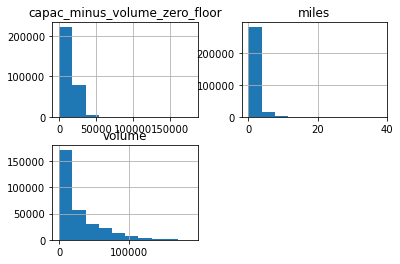

In [8]:
# Examine distribution of the different link attributes.
edges.hist(column = ['capac_minus_volume_zero_floor', 'volume', 'miles'])

In [10]:
# Calculate evenness
qs7_metrics = evenness_metrics(dbname)

qs7_metrics

C:\Users\Daniel.Flynn\Anaconda3\envs\FTOTenv\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Evenness,Weighted_Evenness
Evenness_AvailCapac,0.967176,6.065558e+08
Evenness_Vol,0.954815,1.353591e+09
Evenness_Len,0.922944,5.490133e+04


### Next: `Conduct_Link_Removal`

Open the `Conduct_Link_Removal.ipynb` notebook to carry out the disruptions, calculate performance at each step, and view the results.